## AlexNet Model Training Porocess

### Import libraries

In [15]:
import numpy as np
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from time import time
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

### Dataset paths

In [16]:
train_path = 'new_augmentation/train'
valid_path = 'new_augmentation/val'
test_path = 'new_augmentation/test'

### Training classes

In [17]:
train_classes = os.listdir(train_path)

### Training batch sizes

In [18]:
train_batch_size = 16
test_batch_size = 16
valid_batch_size = 16

### Training samples

In [19]:

# Count the number of samples in each directory
train_n = sum([len(files) for r, d, files in os.walk(train_path)])
test_n = sum([len(files) for r, d, files in os.walk(test_path)])
valid_n = sum([len(files) for r, d, files in os.walk(valid_path)])

print(f'Training samples: {train_n}')
print(f'Test samples: {test_n}')
print(f'Validation samples: {valid_n}')

Training samples: 2387
Test samples: 907
Validation samples: 906


In [20]:
train_n = 2387
test_n = 907
valid_n = 906

### Training steps (per epoch)

In [21]:
train_steps = train_n//train_batch_size
valid_steps = valid_n//valid_batch_size
test_steps = test_n//test_batch_size

### Epochs

In [22]:
epochs = 20

### Generate batches

In [23]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(train_path, target_size=(128,128), classes=train_classes, batch_size=train_batch_size)
valid_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(valid_path, target_size=(128,128), classes=train_classes, batch_size=valid_batch_size)
test_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(test_path, target_size=(128,128), classes=train_classes, batch_size=test_batch_size)

Found 2387 images belonging to 9 classes.
Found 906 images belonging to 9 classes.
Found 907 images belonging to 9 classes.


### Base model (Efficientnet)

#### Transfer Learning

In [24]:
base_model = tf.keras.applications.ResNet50(include_top=False,
    weights='imagenet',
    pooling='avg')

In [25]:
x = base_model.output
x = tf.keras.layers.Dense(512, activation='relu')(x)  # Add a dense layer with 512 units
x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout for regularization
x = tf.keras.layers.Dense(256, activation='relu')(x)  # Add another dense layer with 256 units
x = tf.keras.layers.Dropout(0.5)(x)  # Add another dropout layer
output = tf.keras.layers.Dense(len(train_classes), activation='softmax')(x)  # Final output layer
new_model = tf.keras.Model(base_model.input, output)

### Set early stopping
Avoids model overfitting

In [26]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=2,
    mode='max',
    restore_best_weights=True
)

In [27]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

### Generate new model

In [28]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,
    label_smoothing=0,
   reduction="none",
    name="categorical_crossentropy"), metrics=['accuracy'])

### Training

In [29]:
history = new_model.fit(train_batches, validation_data=valid_batches, validation_steps=valid_steps, steps_per_epoch=train_steps, epochs=epochs,callbacks=[es_callback])

Epoch 1/20
149/149 [==============================] - 756s 5s/step - loss: 1.0262 - accuracy: 0.6651 - val_loss: 3.2851 - val_accuracy: 0.4353
Epoch 2/20
149/149 [==============================] - 616s 4s/step - loss: 0.0681 - accuracy: 0.9836 - val_loss: 2.1106 - val_accuracy: 0.6261
Epoch 3/20
149/149 [==============================] - 592s 4s/step - loss: 0.0429 - accuracy: 0.9878 - val_loss: 2.2830 - val_accuracy: 0.5960
Epoch 3: early stopping


### Evaluate training process

In [30]:
results = new_model.evaluate(train_batches,  steps=train_steps)
results

149/149 [==============================] - 117s 788ms/step - loss: 0.0238 - accuracy: 0.9945


[0.023826343938708305, 0.9945470094680786]

#### Loss function

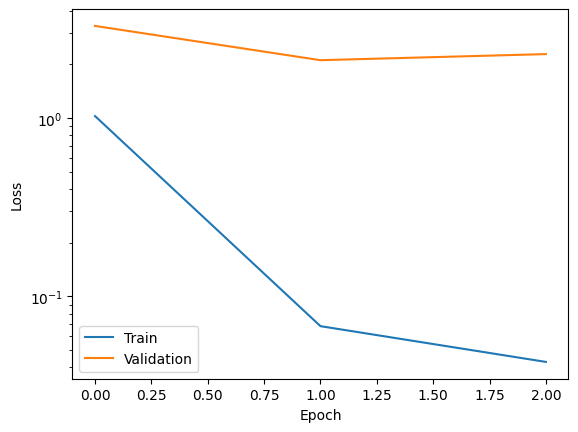

In [31]:
plt.semilogy(history.epoch,  history.history['loss'], label='Train')
plt.semilogy(history.epoch,  history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Accuracy function

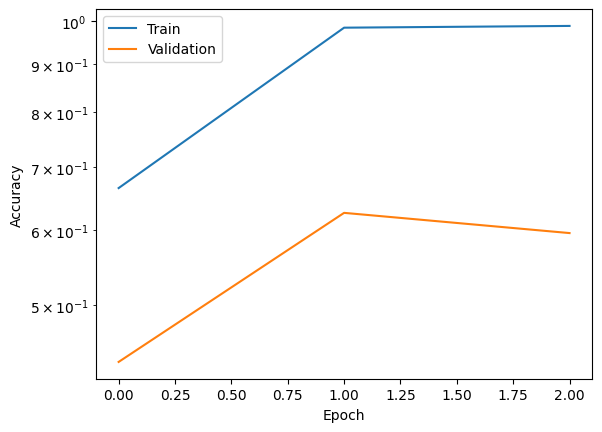

In [32]:
plt.semilogy(history.epoch, history.history['accuracy'], label='Train')
plt.semilogy(history.epoch, history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [33]:
Y_train_pred =new_model.predict(train_batches,train_steps)

150/150 [==============================] - 122s 801ms/step


In [34]:
y_train_pred = np.argmax(Y_train_pred, axis=1)

In [35]:
print(len(train_batches.classes))
print(len(y_train_pred))

2387
2387


#### Confusion matrix

In [36]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming train_batches is your training data generator
# Make predictions on the training set
y_train_pred = new_model.predict(train_batches, steps=train_batches.samples // train_batches.batch_size + 1)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Ensure the lengths match
assert len(train_batches.classes) == len(y_train_pred_classes), "Mismatch in number of samples"

# Compute the confusion matrix
cm_train = confusion_matrix(train_batches.classes, y_train_pred_classes)

print(cm_train)

# cm_train = confusion_matrix(train_batches.classes, y_train_pred)

150/150 [==============================] - 124s 825ms/step
[[72 70 41 32 11 66 50 26 28]
 [78 58 27 22  9 70 57 29 41]
 [25 33 22 17  9 43 22 11 16]
 [31 31 15 22  8 31 17 25 21]
 [17 16 10  6 10 17 13  6  5]
 [62 61 36 37 12 64 53 34 37]
 [51 50 24 29 20 45 31 31 20]
 [29 39 10 17  6 29 32 25 15]
 [34 33 16 17 15 28 23 20 16]]


Text(0.5, 135.7222222222222, 'Predicted label')

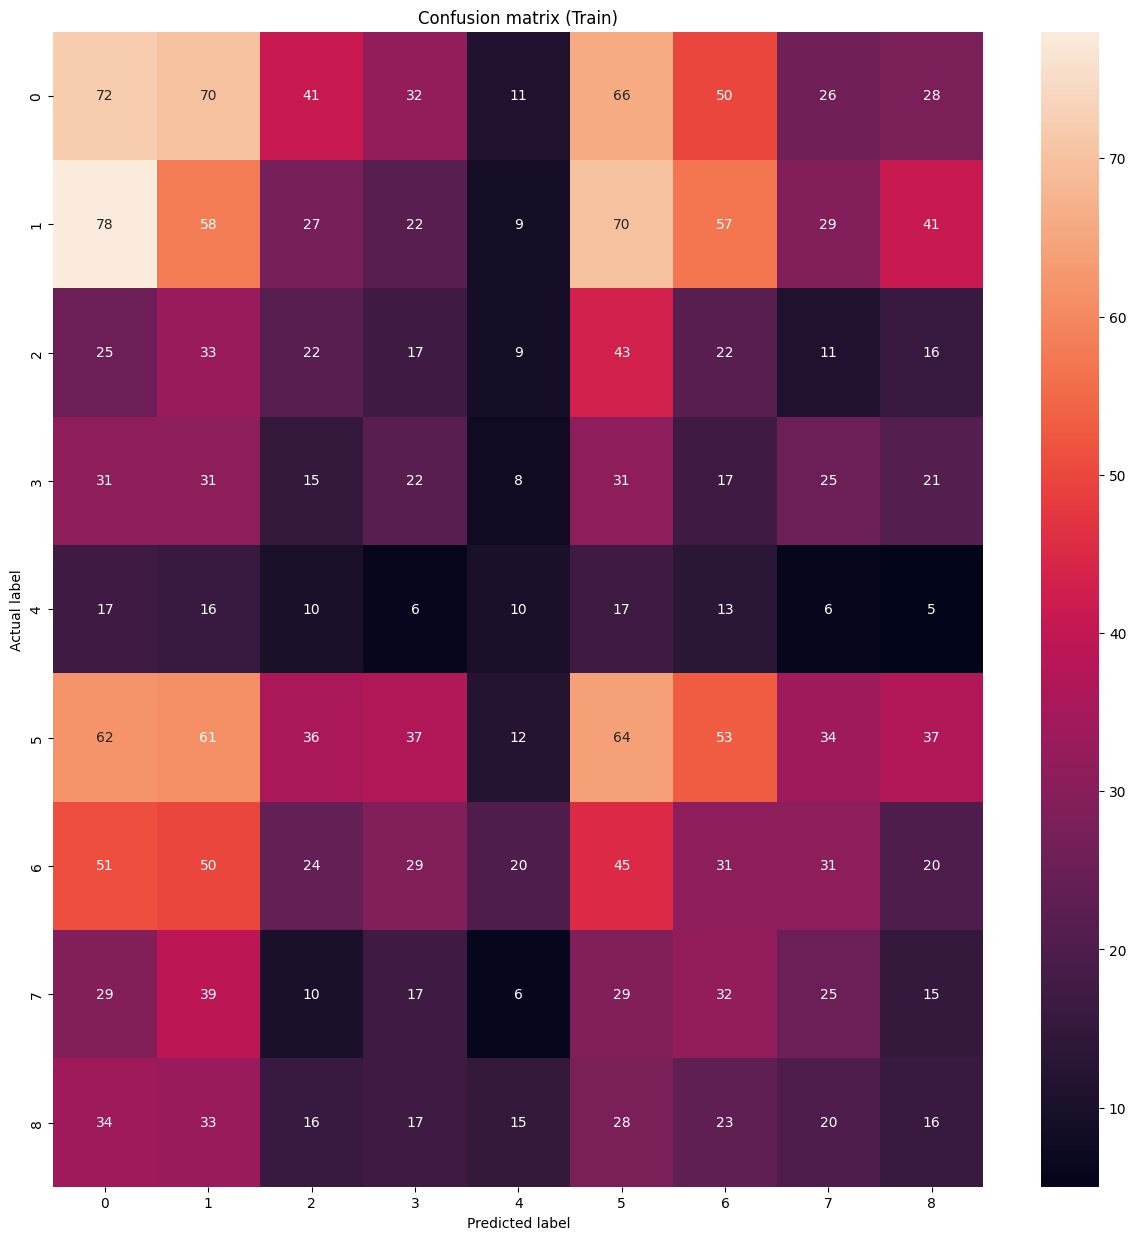

In [37]:
plt.figure(figsize=(15,15))
sns.heatmap(cm_train, annot=True, fmt="d")
plt.title('Confusion matrix (Train)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model testing

In [38]:
Y_pred =new_model.predict(test_batches,test_steps)

57/57 [==============================] - 43s 745ms/step


In [39]:
y_pred = np.argmax(Y_pred, axis=1)

In [40]:
# cm = confusion_matrix(test_batches.classes, y_pred)

from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming test_batches is your test data generator
# Make predictions on the test set
y_pred = new_model.predict(test_batches, steps=test_batches.samples // test_batches.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure the lengths match
assert len(test_batches.classes) == len(y_pred_classes), "Mismatch in number of samples"

# Compute the confusion matrix
cm = confusion_matrix(test_batches.classes, y_pred_classes)

print(cm)

 3/57 [>.............................] - ETA: 44s

57/57 [==============================] - 44s 772ms/step
[[47  0 19  0  0  6 14 11  4]
 [41  0 20  0  0  7 13 16  4]
 [39  1 17  0  0  9 11 16  7]
 [53  1 18  0  0  8  9 10  2]
 [42  1 16  0  0  5 23 12  2]
 [47  0 14  0  0 10 14 14  2]
 [49  0 22  0  0  6 10 10  3]
 [39  1 20  0  0  8 11 19  3]
 [47  0 20  0  0  5  5 22  2]]


Text(0.5, 135.7222222222222, 'Predicted label')

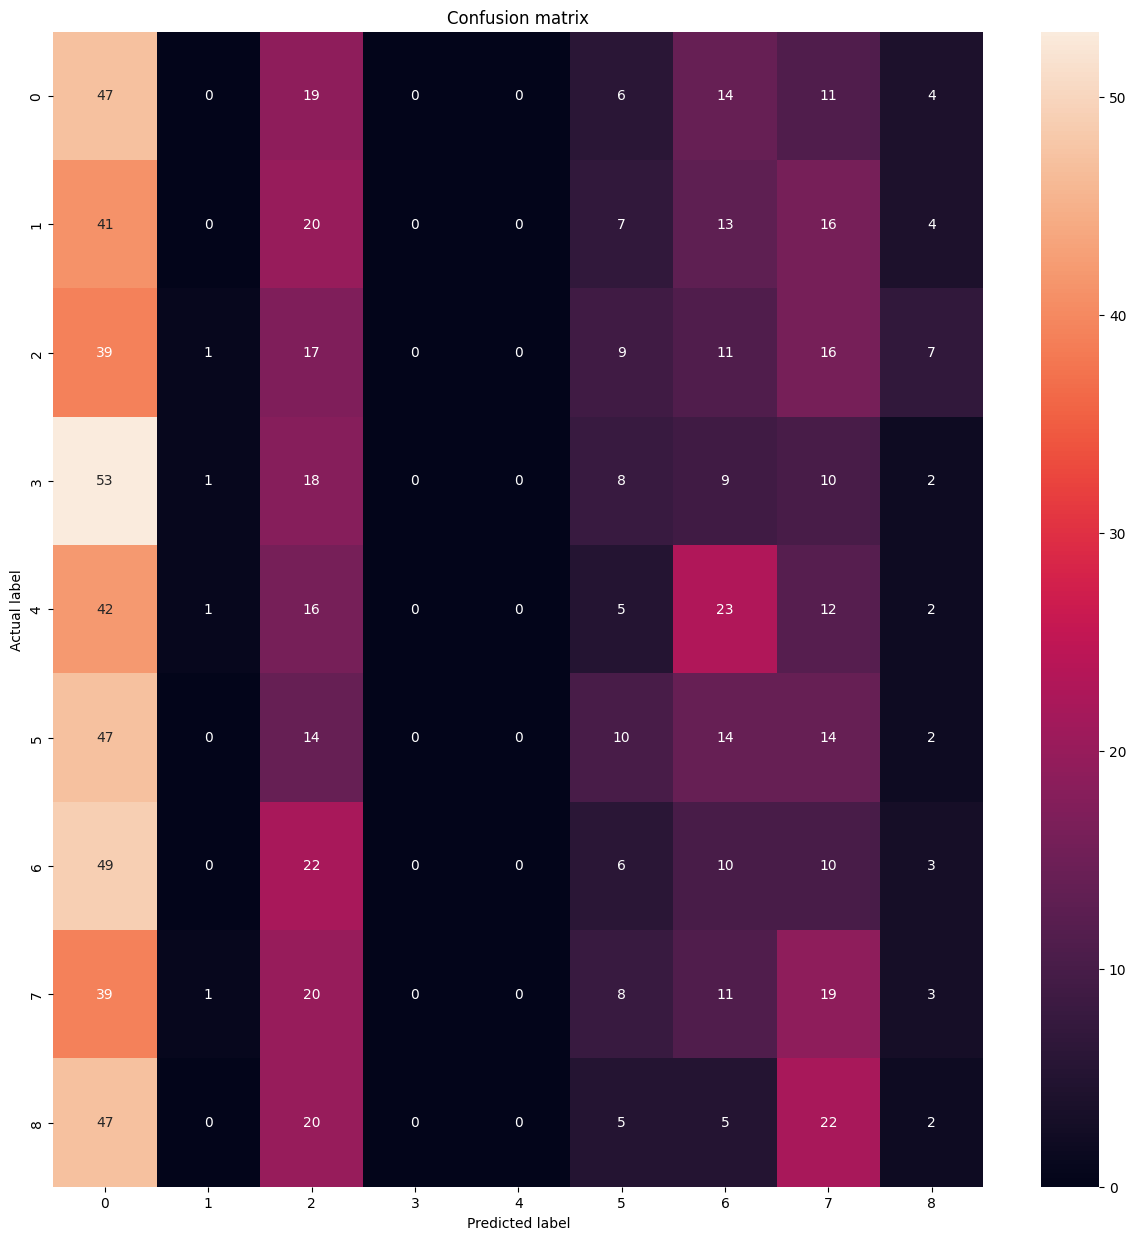

In [41]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Evaluate model on test set

In [42]:
test_loss, test_accuracy = new_model.evaluate(test_batches, steps=test_steps)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

56/56 [==============================] - 43s 761ms/step - loss: 4.1299 - accuracy: 0.3125
Test Loss: 4.129887104034424, Test Accuracy: 0.3125


Evaluation Matrix

In [43]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = new_model.predict(test_batches, steps=test_batches.samples // test_batches.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure the lengths match
assert len(test_batches.classes) == len(y_pred_classes), "Mismatch in number of samples"

# Generate classification report
report = classification_report(test_batches.classes, y_pred_classes, target_names=test_batches.class_indices.keys())
print(report)

57/57 [==============================] - 41s 723ms/step
              precision    recall  f1-score   support

   Duryodhan       0.10      0.40      0.16       101
       Ganga       0.50      0.02      0.04       101
        Lali       0.05      0.09      0.07       100
  Parashuram       0.00      0.00      0.00       101
        Raju       0.00      0.00      0.00       101
Sivilbahadur       0.09      0.06      0.07       101
        Sonu       0.10      0.11      0.10       100
   Tirathram       0.15      0.19      0.16       101
    Yoglaxmi       0.10      0.03      0.05       101

    accuracy                           0.10       907
   macro avg       0.12      0.10      0.07       907
weighted avg       0.12      0.10      0.07       907



### Save model

In [44]:
new_model.save('restnet50v4_new')

INFO:tensorflow:Assets written to: restnet50v4_new\assets


INFO:tensorflow:Assets written to: restnet50v4_new\assets
